In [21]:
import socket
import argparse
import os
import json
import datetime
import time
from scipy.optimize import least_squares
import numpy as np
import utm
import matplotlib.pyplot as plt; plt.ion()

In [2]:
tx = (477954, 3638577, 11, 'S')
txp = 100
n = 4
k = 1
d = 1000

In [6]:
UDP_PORT = 9000
UDP_IP = '255.255.255.255'
sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
sock.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
sock.setsockopt(socket.SOL_SOCKET, socket.SO_BROADCAST, 1)
prevTime = datetime.datetime.now()

In [7]:
tx_loc = np.array([tx[0], tx[1], 0])
dx_loc = np.array([tx[0] - 100, tx[1], 30])
vx = np.array([[5, 1, 0],
                [-1, 5, 0],
                [-5, -1, 0],
                [1, -5, 0]])
n1 = 30
c_loc = dx_loc
leg = 0
msgs = []
while leg < 4:
    for i in range(n1):
        now = datetime.datetime.now()
        if (now - prevTime).total_seconds() > 1:
            d
#             print(msg)
            sock.sendto(msg.encode("UTF-8"), (UDP_IP, UDP_PORT))
            msgs.append(msg)
            prevTime = now
        c_loc += vx[leg,:]
        dist = np.linalg.norm(tx_loc - c_loc)
        R = txp - 10 * n * np.log10(dist) + k
        ll = utm.to_latlon(c_loc[0], c_loc[1], tx[2], tx[3])
        msg = '{"ping": {"time": %d, "lat": %.10f, "lon": %.10f, "alt": %.5f, "amp": %.5f, "txf": %d}}\n' % (time.mktime(now.timetuple()), ll[0], ll[1], dx_loc[2], R, 173965000)
#         print(msg)
        sock.sendto(msg.encode("UTF-8"), (UDP_IP, UDP_PORT))
        msgs.append(msg)
        time.sleep(1)
    leg = (leg + 1)

In [4]:
utm.to_latlon(tx[0], tx[1], tx[2], tx[3])

(32.88512835563356, -117.23569331497244)

In [19]:
pings = [json.loads(msg)['ping'] for msg in msgs if 'ping' in json.loads(msg)]
D_raw = [[float(ping['lat']), float(ping['lon']), float(ping['alt']), float(ping['amp'])] for ping in pings]
loc_utm = [utm.from_latlon(x[0], x[1]) for x in D_raw]
D_utm = np.array([[loc_utm[i][0], loc_utm[i][1], D_raw[i][2], D_raw[i][3]] for i in range(len(D_raw))])

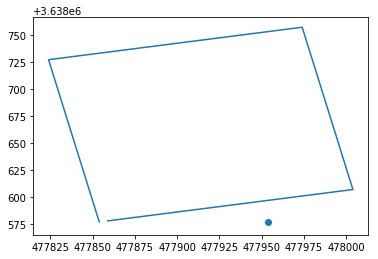

In [35]:
plt.plot(D_utm[:,0], D_utm[:,1])
plt.scatter(tx[0], tx[1])

In [25]:
def distance(x1, y1, z1, x2, y2, z2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2) ** 2 + (z1 - z2) ** 2)

In [26]:
def residuals(p, data):
    xt = p[0]
    yt = p[1]
    zt = 0
    k = p[2]
    n = p[3]
    xd = data[:,0]
    yd = data[:,1]
    zd = data[:,2]
    R = data[:,3]
    
    residuals = np.zeros(len(xd))
    for i in range(len(xd)):
        residuals[i] = R[i] - k - 10 * n * np.log10(distance(xd[i], yd[i], zd[i], xt, yt, zt))
    return residuals

In [43]:
x0 = np.array([np.mean(D_utm[:,0]), np.mean(D_utm[:,1]), np.max(D_utm[:,3]), -4])

res = least_squares(residuals, x0, kwargs={"data":D_utm})

In [44]:
print(res)

 active_mask: array([0., 0., 0., 0.])
        cost: 4.573077513075595e-10
         fun: array([-3.67674886e-06, -5.33637532e-07,  3.71730108e-06,  3.40800763e-06,
       -3.52347163e-06, -4.30300636e-06, -1.87001243e-06,  2.23220752e-06,
       -1.77999750e-06,  7.98030129e-07, -1.60295937e-06, -2.08375549e-06,
       -1.36389710e-06, -5.19910955e-07,  2.48738051e-06,  2.93034618e-06,
       -4.01345154e-07, -2.98179621e-07,  1.15155616e-06, -1.72594428e-06,
        5.50520728e-06, -1.16526948e-07,  1.03028714e-06, -2.53436635e-06,
        3.39770764e-07,  2.59555203e-06,  1.82701709e-06,  4.45366513e-06,
       -2.92599277e-06, -6.97169710e-07,  1.78358809e-06,  1.29516948e-06,
       -2.18231942e-06, -4.94615610e-06,  5.19976879e-07,  1.57144278e-06,
       -5.29677962e-07,  1.71793950e-06,  1.51312955e-06,  6.43228773e-07,
       -4.91939058e-06, -1.00037258e-06, -3.02024553e-06, -7.00646368e-07,
       -4.63266788e-06,  1.25304767e-06, -1.67528667e-06,  2.86117429e-06,
        5.95

In [32]:
tx

(477954, 3638577, 11, 'S')